In [17]:
import fastapi
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import regularizers
from google.colab import files


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Pet_project_logistic_Regression/xray_dataset_covid19/train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

NameError: name 'ImageDataGenerator' is not defined

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Pet_project_logistic_Regression/xray_dataset_covid19/test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 40 images belonging to 2 classes.


In [ ]:
images, labels = next(training_set)
test_images, test_labels = next(test_set)

In [ ]:
print(test_labels.shape)

(32,)


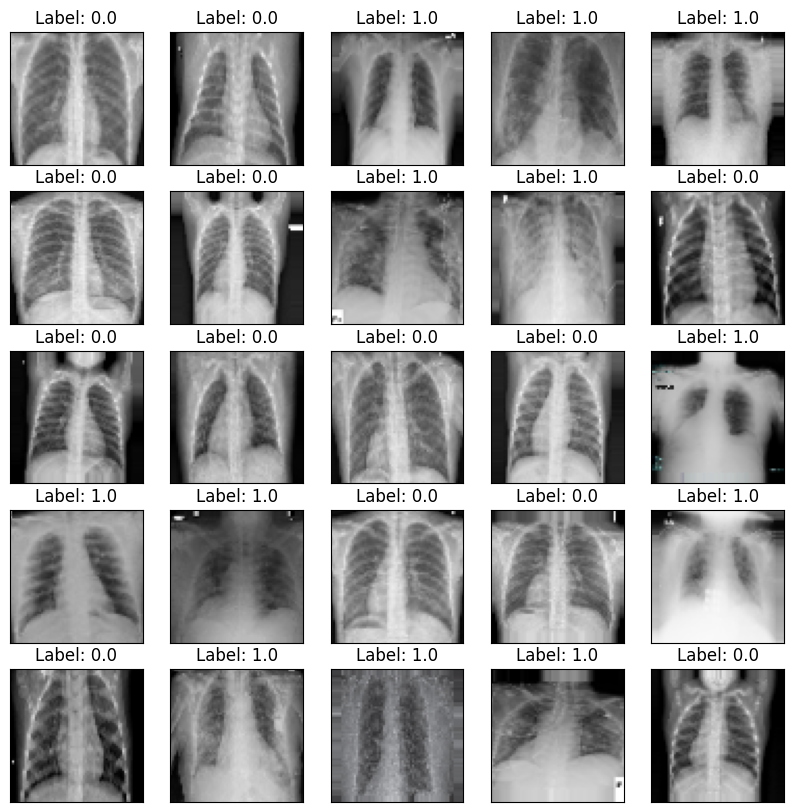

In [ ]:
plt.figure(figsize = (10,10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i])
    plt.title('Label: {}'.format(labels[i]))
plt.show()

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=16),
                     kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                     activation='relu',
                     kernel_regularizer=regularizers.l2(hp.Choice('conv_1_regularizer', values=[0.01, 0.001, 0.0001])),
                     input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=hp.Int('conv_2_filters', min_value=32, max_value=64, step=16),
                     kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
                     activation='relu',
                     kernel_regularizer=regularizers.l2(hp.Choice('conv_2_regularizer', values=[0.01, 0.001, 0.0001]))))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=16),
                    activation='relu',
                    kernel_regularizer=regularizers.l2(hp.Choice('dense_regularizer', values=[0.01, 0.001, 0.0001]))))

    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
tuner_covid_reg = RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 15,
    executions_per_trial = 3,
    directory = 'tuner_reg',
    project_name = 'Covid_19_reg'
)

tuner_covid_reg.search(training_set, epochs = 25, validation_data = (test_set))

Trial 15 Complete [00h 11m 19s]
val_accuracy: 0.9916666746139526

Best val_accuracy So Far: 1.0
Total elapsed time: 02h 32m 45s


In [ ]:
best_hyperparameters = tuner_covid_reg.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparametrs:")
print(best_hyperparameters.values)


Best Hyperparametrs:
{'conv_1_filters': 32, 'conv_1_kernel': 5, 'conv_1_regularizer': 0.001, 'conv_2_filters': 48, 'conv_2_kernel': 5, 'conv_2_regularizer': 0.0001, 'dense_units': 128, 'dense_regularizer': 0.001}


In [ ]:
best_model = build_model(best_hyperparameters)
history = best_model.fit(training_set, epochs=25, validation_data=test_set)

Epoch 1/25
5/5 [==============================] - 9s 2s/step - loss: 0.9735 - accuracy: 0.5608 - val_loss: 0.8688 - val_accuracy: 0.5000
Epoch 2/25
5/5 [==============================] - 6s 1s/step - loss: 0.8444 - accuracy: 0.5473 - val_loss: 0.7475 - val_accuracy: 0.9250
Epoch 3/25
5/5 [==============================] - 8s 2s/step - loss: 0.7544 - accuracy: 0.7635 - val_loss: 0.5723 - val_accuracy: 0.9750
Epoch 4/25
5/5 [==============================] - 6s 1s/step - loss: 0.7313 - accuracy: 0.6419 - val_loss: 0.5425 - val_accuracy: 0.9000
Epoch 5/25
5/5 [==============================] - 8s 2s/step - loss: 0.6051 - accuracy: 0.7432 - val_loss: 0.3797 - val_accuracy: 1.0000
Epoch 6/25
5/5 [==============================] - 6s 1s/step - loss: 0.5300 - accuracy: 0.8243 - val_loss: 0.2438 - val_accuracy: 0.9750
Epoch 7/25
5/5 [==============================] - 7s 1s/step - loss: 0.4728 - accuracy: 0.8311 - val_loss: 0.2267 - val_accuracy: 0.9750
Epoch 8/25
5/5 [=========================

In [ ]:
train_loss, train_accuracy = best_model.evaluate(training_set)
test_loss, test_accuracy = best_model.evaluate(test_set)
print(f'\ntest loss: {test_loss}, test accuracy: {test_accuracy}')
print(f'Train Loss: {train_loss}, train accuracy: {train_accuracy}')

2/2 [==============================] - 1s 182ms/step - loss: 0.1273 - accuracy: 0.9750

test loss: 0.127292662858963, test accuracy: 0.9750000238418579
Train Loss: 0.18639039993286133, train accuracy: 0.9324324131011963


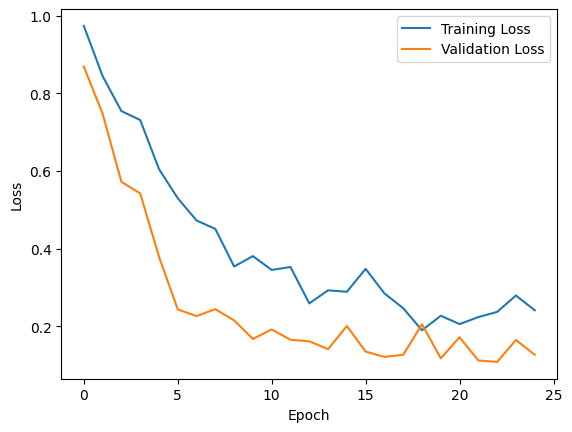

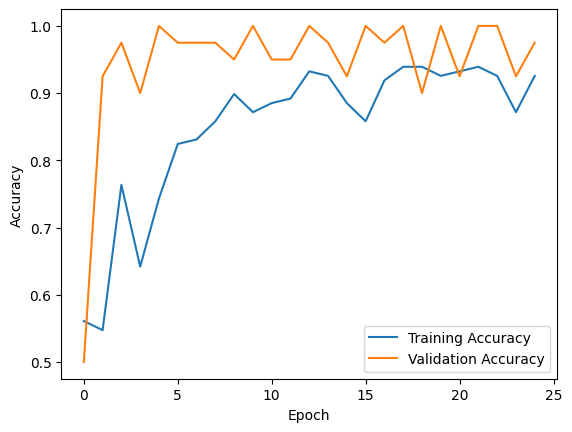

In [ ]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 143ms/step


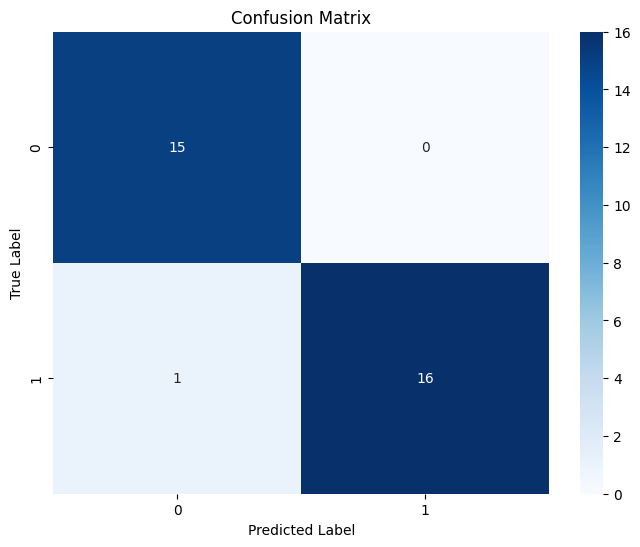

In [ ]:
predictions = best_model.predict(test_images)
y_pred = (predictions > 0.5)
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

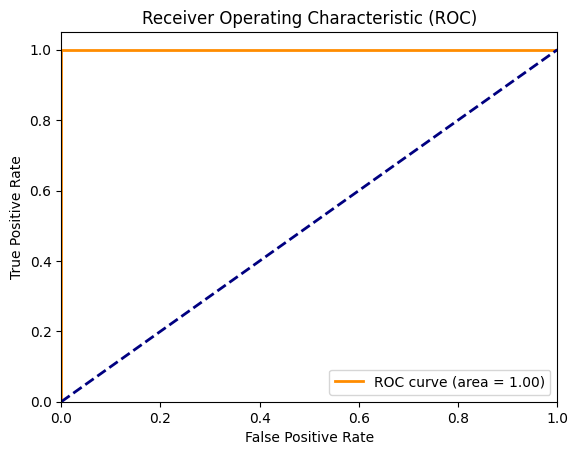

In [ ]:
fpr, tpr, thresholds = roc_curve(test_labels, predictions)
auc_score = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [19]:
best_model.save('COVID.h5')

NameError: name 'best_model' is not defined